Link: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/subtract-rasters-in-python/

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

# Open raster data
with rio.open(lidar_dem_path) as lidar_dem:
    lidar_dem_im = lidar_dem.read(1, masked=True)
    
    # Get bounds for plotting
    bounds = plotting_extent(lidar_dem)

In [3]:
# Define relative path to file
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial", 
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DSM.tif")

with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dsm_im = lidar_dsm.read(1, masked=True)
    
lidar_dsm_im

masked_array(
  data=[[--, --, --, ..., 1695.6300048828125, 1695.5899658203125,
         1696.3900146484375],
        [--, --, --, ..., 1695.5999755859375, 1695.6300048828125, 1697.0],
        [--, --, --, ..., 1695.3800048828125, 1695.43994140625,
         1695.449951171875],
        ...,
        [--, --, --, ..., 1681.449951171875, 1681.3900146484375, 1681.25],
        [--, --, --, ..., 1681.719970703125, 1681.5699462890625,
         1681.5599365234375],
        [--, --, --, ..., 1681.8900146484375, 1681.8099365234375,
         1681.739990234375]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [4]:
# Are the bounds the same?
print("Is the spatial extent the same?", 
      lidar_dem.bounds == lidar_dsm.bounds)

# Is the resolution the same ??
print("Is the resolution the same?", 
      lidar_dem.res == lidar_dsm.res)

Is the spatial extent the same? True
Is the resolution the same? True


In [5]:
# Calculate canopy height model
lidar_chm_im = lidar_dsm_im - lidar_dem_im

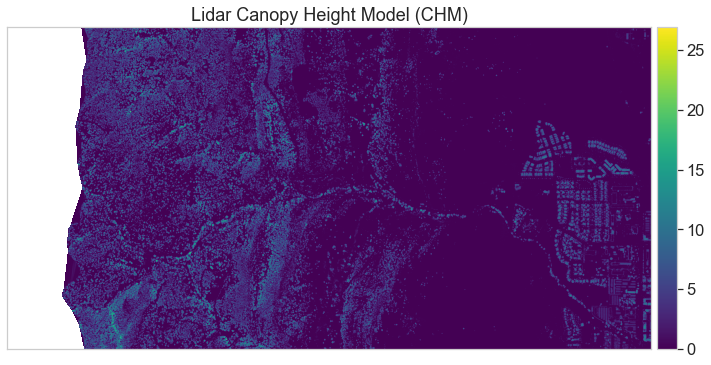

In [6]:
# Plot the data
ep.plot_bands(lidar_chm_im, 
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)",
              scale=False)
plt.show()

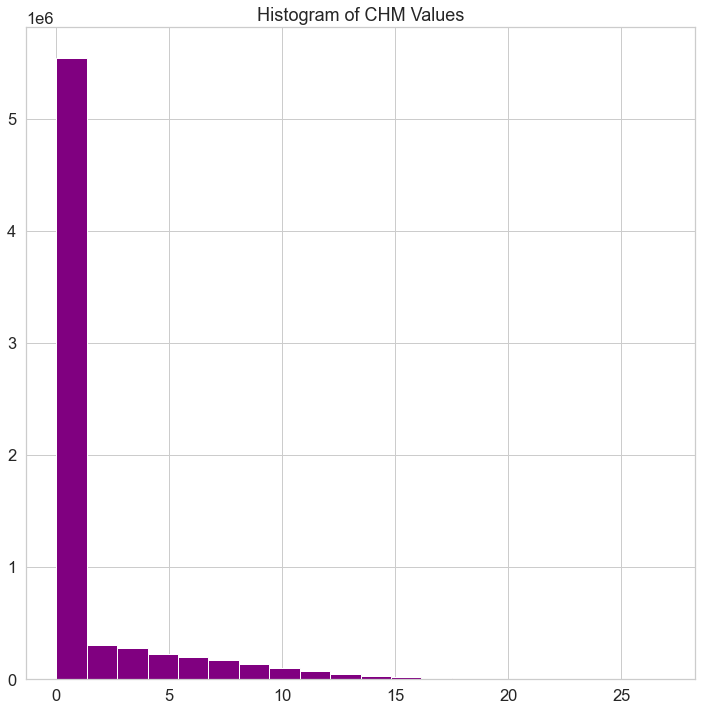

In [7]:
ep.hist(lidar_chm_im, 
        colors = 'purple',
        title="Histogram of CHM Values")
plt.show()

In [8]:
print('CHM minimum value: ', lidar_chm_im.min())
print('CHM max value: ', lidar_chm_im.max())

CHM minimum value:  0.0
CHM max value:  26.930054


In [9]:
if os.path.exists('data/colorado-flood/spatial/outputs'):
    print('The directory exists!')
else:
    os.makedirs('data/colorado-flood/spatial/outputs')

The directory exists!


In [10]:
lidar_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

In [11]:
lidar_chm_im.min()
lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [12]:
# fill the masked pixels with a set no data value
nodatavalue = -999.0
lidar_chm_im_fi = np.ma.filled(lidar_chm_im, fill_value=nodatavalue)
lidar_chm_im_fi.min(), nodatavalue

(-999.0, -999.0)

In [13]:
# Update the metadata to ensure the nodata value is properly documented 

# Create dictionary copy
chm_meta = lidar_dem.meta.copy()

# Update the nodata value to be an easier to use number
chm_meta.update({'nodata': nodatavalue})
chm_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999.0,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

In [14]:
# Note the width and height of the dem above. 
# Is the numpy array shape the same?
lidar_chm_im_fi.shape

(2000, 4000)

In [15]:
out_path = os.path.join("data", "colorado-flood", "spatial",
                        "outputs", "lidar_chm.tif")

with rio.open(out_path, 'w', **chm_meta) as outf:
    outf.write(lidar_chm_im_fi, 1)